In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot
from joblib import dump, load
from pickle import load

from keras import models
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [13]:
# importing the data
aapl_data = pd.read_csv("Stock_data.csv")

In [20]:
aapl_data

,Open,High,Low,Close,Volume,SMA-200,EMA-12,EMA-26,MACD,MACD_Signal,RSI_14
0,22.691786,23.225000,22.535713,23.206785,549771600,20.707125,23.127460,23.430805,-0.303346,-0.173722,43.858227
1,23.173929,23.313929,23.000000,23.021786,389037600,20.748800,23.111202,23.400508,-0.289305,-0.196839,33.945587
2,22.842501,22.930714,22.500000,22.594286,476624400,20.787943,23.031677,23.340788,-0.309111,-0.219293,34.627039
3,22.537500,22.563213,21.772142,21.780001,744086000,20.822195,22.839111,23.225174,-0.386063,-0.252647,30.518200
4,21.872143,22.692142,21.812857,22.643929,546730800,20.859986,22.809083,23.182119,-0.373035,-0.276725,40.872590
...,...,...,...,...,...,...,...,...,...,...,...
2790,190.250000,190.380005,188.570007,189.690002,50922700,173.581850,184.277170,180.649011,3.628158,2.185966,88.128922
2791,189.889999,191.910004,189.880005,191.449997,46505100,173.766600,185.380682,181.449084,3.931597,2.535092,88.697589
2792,191.410004,191.520004,189.740005,190.639999,38134500,173.961150,186.189807,182.129893,4.059914,2.840057,84.258111
2793,191.490005,192.929993,190.830002,191.309998,39617700,174.144450,186.977529,182.809901,4.167628,3.105571,82.102790


In [14]:
aapl_data.drop(columns=["Date","Adj Close"],inplace=True)

In [15]:
feature_columns = [col for col in aapl_data.columns if col != "Close"]

In [16]:
split_point = int(len(aapl_data)*0.8)

In [17]:
def create_windowed_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data) - n_steps):
        seq_x, seq_y = data[i:i+n_steps][feature_columns], data.iloc[i+n_steps]['Close']
        X.append(seq_x.values)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [18]:
def data_split(data, n_steps, test_size):
    # Create the windowed data
    X, y = create_windowed_data(data, n_steps)
    
    # Calculate the index for the split point
    test_samples = int(len(X) * test_size)
    split_point = len(X) - test_samples

    # Split the data
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    return X_train, X_test, y_train, y_test

In [21]:
n_steps = 10
test_size = 0.2
X_train, X_test, y_train, y_test = data_split(aapl_data, n_steps, test_size)

# Modeling

## LSTM Network 

In [25]:
class StockPricePredictorLSTM:
    def __init__(self, n_steps, n_features, units=50, optimizer='adam', loss='mean_squared_error'):
        self.n_steps = n_steps
        self.n_features = n_features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.y_scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = self.build_model(units, optimizer, loss)

    def build_model(self, units, optimizer, loss):
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(self.n_steps, self.n_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=units))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def fit(self, X, y, epochs=100, batch_size=32, validation_split=0.1):
        # Reshape from 3D to 2D
        nsamples, nx, ny = X.shape
        X_2D = X.reshape((nsamples, nx*ny))

        # Scale the data
        X_scaled_2D = self.scaler.fit_transform(X_2D)

        # Reshape back to 3D
        X_scaled = X_scaled_2D.reshape((nsamples, nx, ny))

        # Scale the target
        y_scaled = self.y_scaler.fit_transform(y.reshape(-1, 1))

        # Fit the model
        self.history = self.model.fit(
            X_scaled, y_scaled,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        )

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], 'bo-', label='Training loss')
        plt.plot(self.history.history['val_loss'], 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, X):
        # Reshape from 3D to 2D
        nsamples, nx, ny = X.shape
        X_2D = X.reshape((nsamples, nx*ny))
        X_scaled_2D = self.scaler.transform(X_2D)
        X_scaled = X_scaled_2D.reshape((nsamples, nx, ny))
        y_pred_scaled = self.model.predict(X_scaled)
        y_pred = self.y_scaler.inverse_transform(y_pred_scaled)
        return y_pred

    def plot_predictions(self, y_true, y_pred):
        plt.figure(figsize=(10, 6))
        plt.plot(y_true, color='blue', label='Actual Stock Price')
        plt.plot(y_pred, color='red', linestyle='--', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
    def evaluation(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
        rmsde = np.sqrt(mean_squared_error(y_true, y_pred))
        
        metrics = {'MAE': mae, 'MAPE': mape, 'R2': r2, 'RMSPE': rmspe, 'RMSDE': rmsde}
        for metric, value in metrics.items():
            print(f"{metric}: {value:.2f}")
        
        return metrics
    
        
    def save_scaler(self, scaler_path, y_scaler_path):
        dump(self.scaler, scaler_path)
        dump(self.y_scaler, y_scaler_path)
    
    def save_model(self, file_path):
        self.model.save(file_path)
        

n_steps = 10
n_features = 10

predictor = StockPricePredictorLSTM(n_steps=n_steps, n_features=n_features)
predictor.fit(X_train, y_train, epochs=100, batch_size=32)
y_pred = predictor.predict(X_test)


predictor.save_model('Models/lstm_model.h5')
predictor.save_scaler('Scaler/lstm_scaler/X_scaler.joblib', 'Scaler/lstm_scaler/y_scaler.joblib')


Epoch 1/100
63/63 [==============================] - 7s 27ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: 7.6855e-04 - val_loss: 0.0024
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 8.6137e-04 - val_loss: 0.0026
Epoch 5/100
63/63 [==============================] - 1s 22ms/step - loss: 7.2521e-04 - val_loss: 7.0887e-04
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 6.9775e-04 - val_loss: 0.0015
Epoch 7/100
63/63 [==============================] - 1s 13ms/step - loss: 6.4094e-04 - val_loss: 6.6320e-04
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: 6.0108e-04 - val_loss: 8.1525e-04
Epoch 9/100
63/63 [==============================] - 1s 11ms/step - loss: 5.9268e-04 - val_loss: 7.0201e-04
Epoch 10/100
63/63 [==============================] - 1s

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


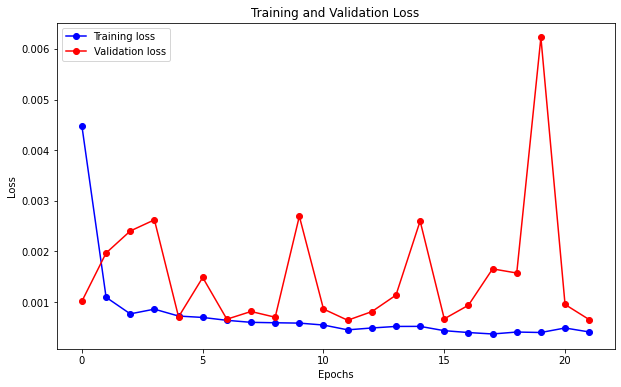

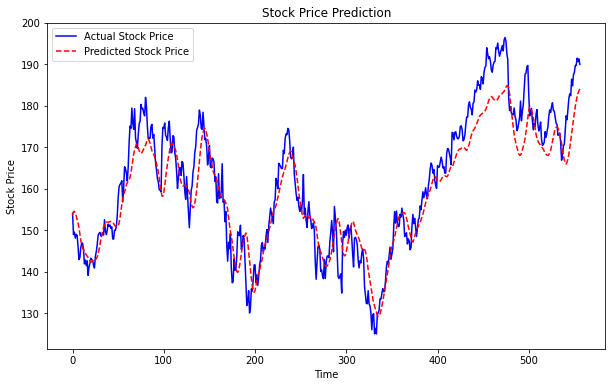

MAE: 4.81
MAPE: 10.60
R2: 0.86
RMSPE: 13.05
RMSDE: 6.11


In [26]:
predictor.plot_loss()

predictor.plot_predictions(y_test, y_pred)

metrics = predictor.evaluation(y_test, y_pred)

In [30]:
from joblib import load as joblib_load

LSTM_model = models.load_model('Models/lstm_model.h5')
X_scaler = open('Scaler/lstm_scaler/X_scaler.joblib', 'rb')
y_scaler = open('Scaler/lstm_scaler/y_scaler.joblib', 'rb')

X_scaler = joblib_load(X_scaler)
y_scaler = joblib_load(y_scaler)

In [33]:
def predict_next_days(model, X_scaler, y_scaler, data, n_days, n_steps=10, n_features=10):
    predictions = []
    feature_columns = ['Open', 'High', 'Low', 'Volume', 'SMA-200', 'EMA-12', 'EMA-26', 'MACD', 
                       'MACD_Signal', 'RSI_14']

    data_copy = data.copy()

    for _ in range(n_days):
        input_data = data_copy[feature_columns].tail(n_steps)

        # Flatten the data and reshape for the scaler to (1, n_steps * n_features)
        input_data_flattened = input_data.values.flatten().reshape(1, n_steps * n_features)

        # Scale the flattened data
        input_data_scaled = X_scaler.transform(input_data_flattened)

        # Reshape the scaled data back to 3D format for the model: (1, n_steps, n_features)
        input_data_reshaped = input_data_scaled.reshape(1, n_steps, n_features)

        predicted_price_scaled = model.predict(input_data_reshaped)

        predicted_price = y_scaler.inverse_transform(predicted_price_scaled)[0, 0]

        predictions.append(predicted_price)

        next_row = input_data.iloc[-1].copy()
        for col in feature_columns:
            next_row[col] = input_data[col].mean()  
        data_copy = pd.concat([data_copy, next_row], ignore_index=True)

    return predictions


n_days = 1  # Number of days to predict
predicted_prices = predict_next_days(LSTM_model, X_scaler, y_scaler, aapl_data, n_days)
predicted_prices


1/1 [==============================] - 0s 72ms/step


[184.20992]